## Memory

Memory提供了对上下文消息的存储和访问机制，LangChain 提供了许多实用程序来向系统添加内存。这些实用程序可以自己使用，也可以无缝地合并到一个链中。

在 LangChain，大多数与内存相关的功能都被标记为 *beta* 版，原因有二:

- 大多数功能还没有准备好生产

- 大多数功能使用遗留链，而不是较新的 LCEL 语法。

**主要的例外是 ChatMessageHistory 功能，这个功能基本上已经准备就绪，并且与 LCEL 集成。[https://python.langchain.com/v0.1/docs/integrations/memory/]**

In [8]:
# 环境变量设置
import os
os.environ["OPENAI_API_KEY"] = "sk-xxx"
os.environ["OPENAI_API_BASE"] = "https://api.chatanywhere.tech/v1"

### 概述

链中的Memory的运转流程如下：

1. 在接收到初始用户输入之后，但在执行核心逻辑之前，链将从其内存系统读取并增加用户输入。

2. 在执行核心逻辑之后，但在返回答案之前，链将把当前运行的输入和输出写入内存，以便在以后的运行中引用它们。

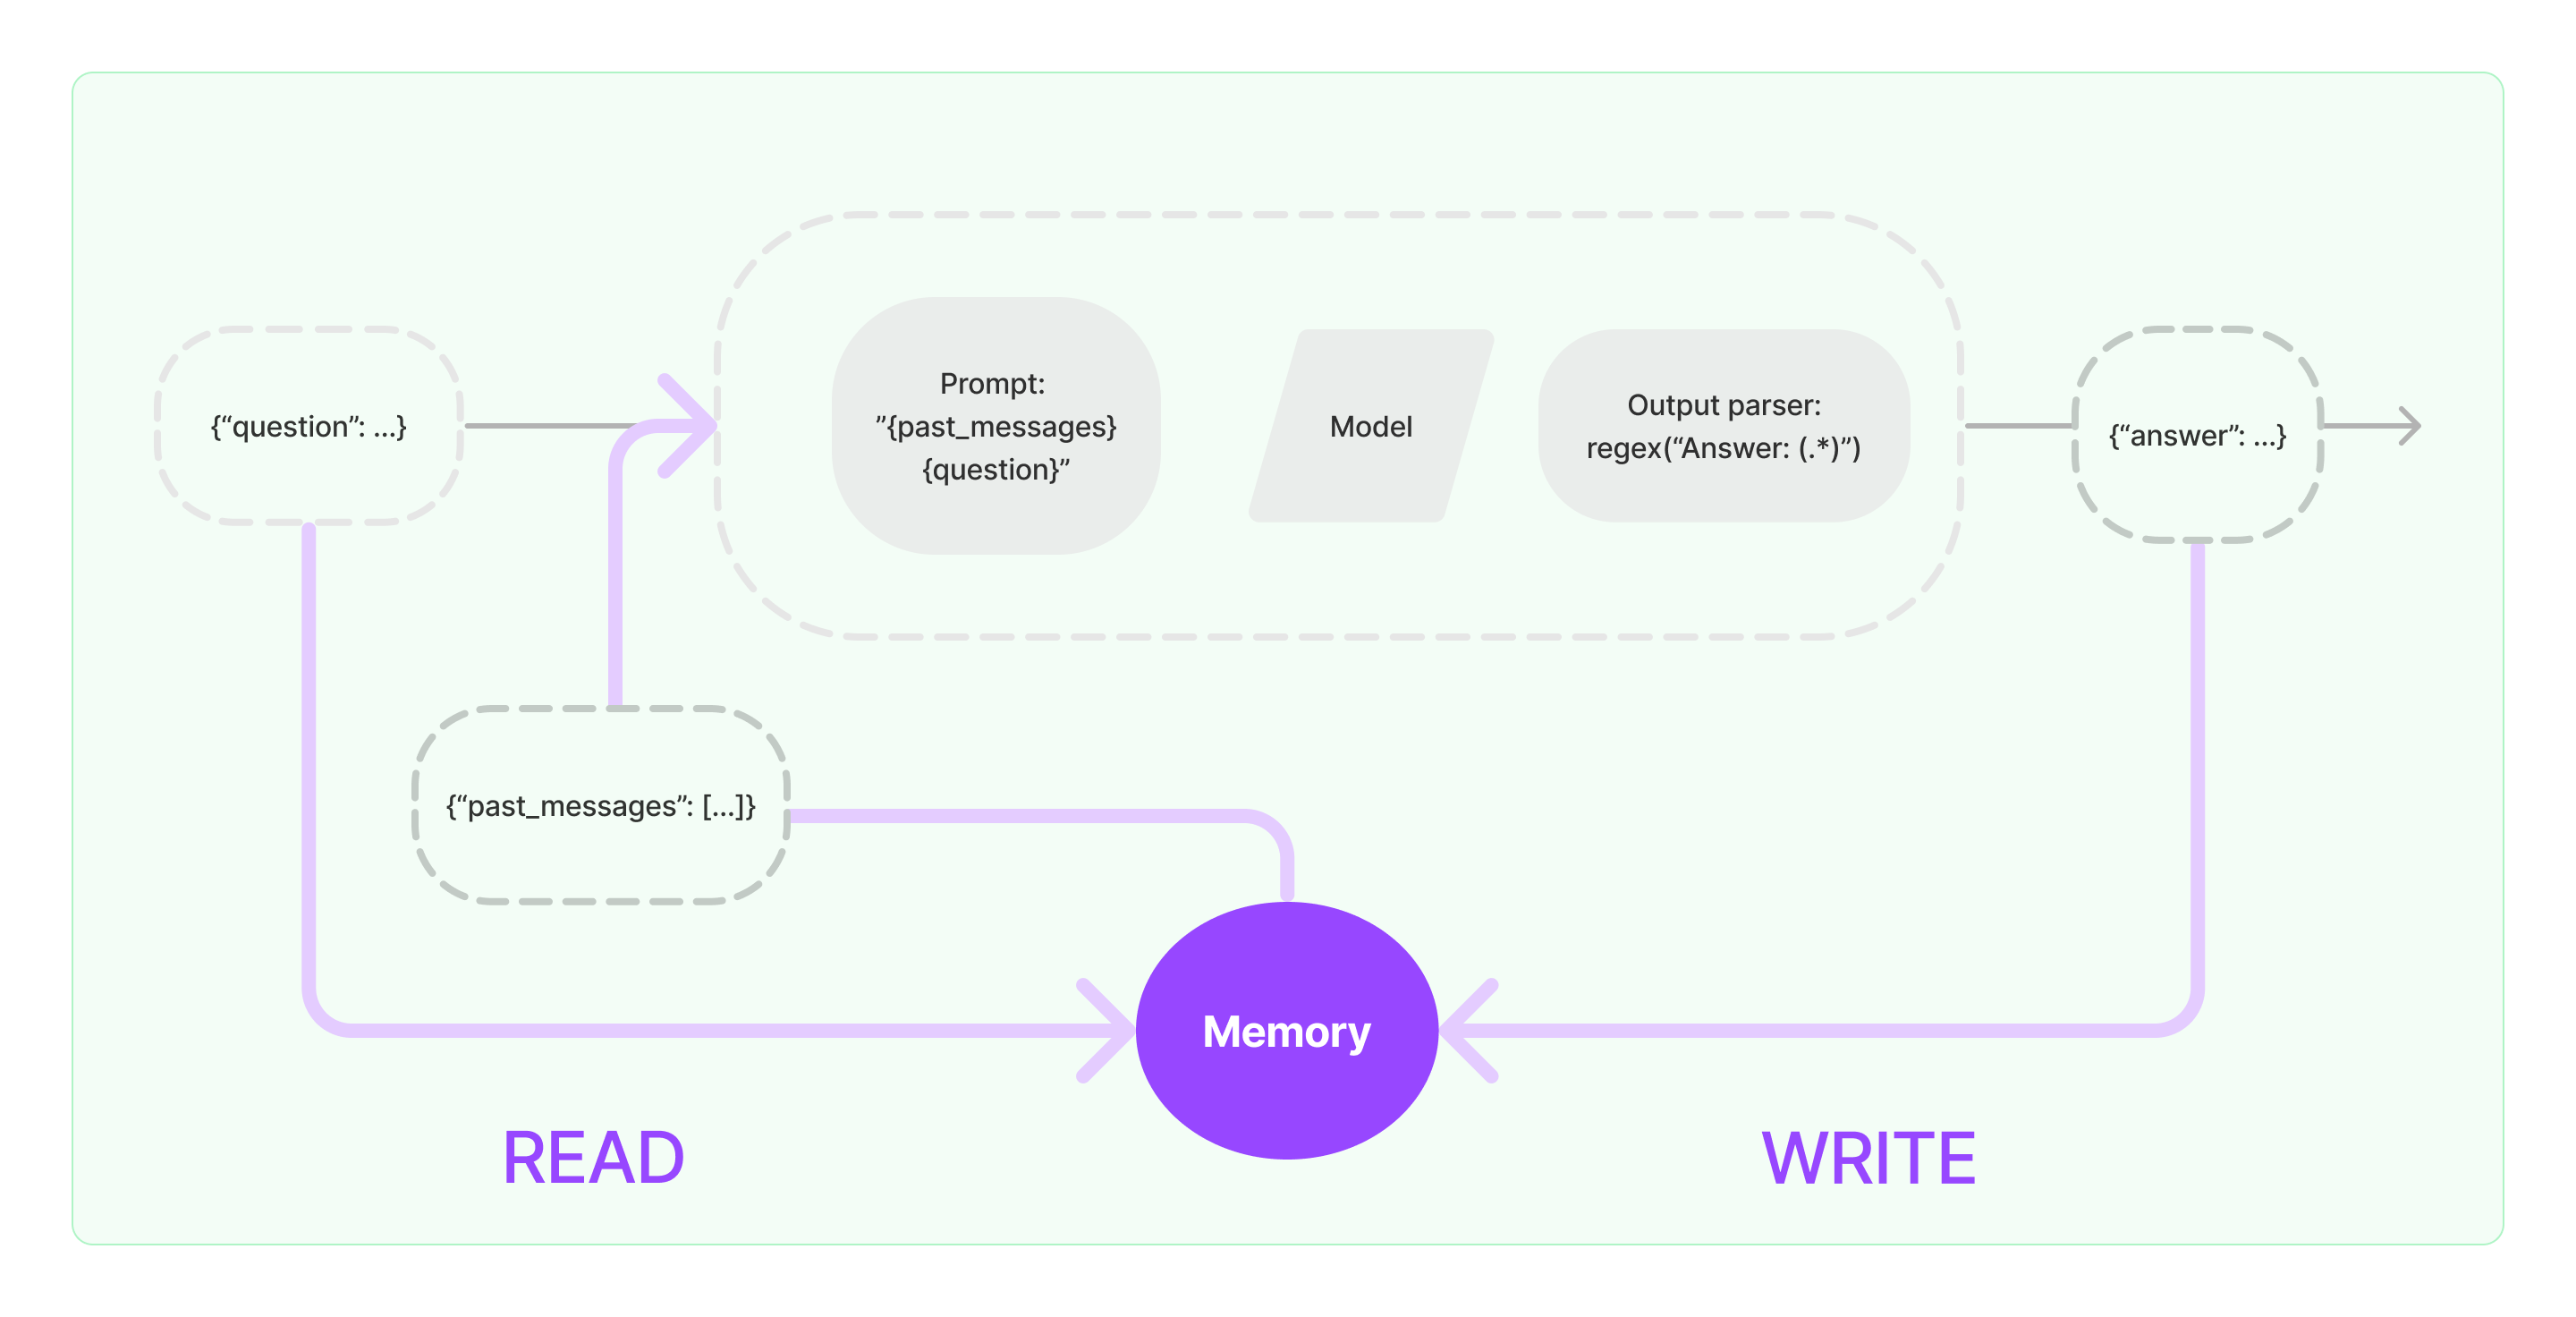

设计核心：
- 状态是如何存储的

- 如何查询状态

### 基础示例 ConversationBufferMemory 

ConversationBufferMemory 是一种非常简单的内存形式，它只在缓冲区中保存一个聊天消息列表，并将这些消息传递到提示模板中。

In [1]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()
memory.chat_memory.add_user_message("你好！")
memory.chat_memory.add_ai_message("有什么事吗？")

In [2]:
# 查看内存存储的对话
memory.load_memory_variables({})

{'history': 'Human: 你好！\nAI: 有什么事吗？'}

可以通过memory_key来定义返回的memory的key

In [4]:
memory = ConversationBufferMemory(memory_key="chat_history")
memory.chat_memory.add_user_message("你好！")
memory.chat_memory.add_ai_message("有什么事吗？")

memory.load_memory_variables({})

{'chat_history': 'Human: 你好！\nAI: 有什么事吗？'}

默认情况下，ConversationBufferMemor内存内容作为单个字符串返回。如果想要以消息列表的形式返回，可以设置 return_message = True

In [5]:
memory = ConversationBufferMemory(return_messages=True)
memory.chat_memory.add_user_message("你好！")
memory.chat_memory.add_ai_message("有什么事吗？")

In [6]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='你好！'), AIMessage(content='有什么事吗？')]}

#### 在LLM中使用

In [12]:
from langchain_openai import OpenAI
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory


llm = OpenAI(temperature=0)
# 注意“ chat _ history”出现在提示模板中
template = """你是一个可以和人类友好对话的机器人.

之前的对话:
{chat_history}

人类的问题: {question}
回答:"""
prompt = PromptTemplate.from_template(template)
# 需要对齐‘ memory _ key’ = chat_history
memory = ConversationBufferMemory(memory_key="chat_history")
conversation = LLMChain(
    llm=llm,
    prompt=prompt,
    verbose=True,
    memory=memory
)
# conversation = prompt | memory | llm

我们只是传递了‘ questions’变量-‘ chat _ history’由内存填充

In [10]:
conversation({"question": "你好"})

/Users/barry/.pyenv/versions/3.12.2/envs/langchain/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new LLMChain chain...
Prompt after formatting:
你是一个可以和人类友好对话的机器人.

之前的对话:


人类的问题: 你好
回答:

> Finished chain.


{'question': '你好',
 'chat_history': '',
 'text': ' 你好，我是一个可以和人类友好对话的机器人。有什么可以帮助你的吗？'}

#### 使用ChatModel

In [17]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory


llm = ChatOpenAI()
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "你是一个可以和人类友好对话的机器人."
        ),
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("{question}")
    ]
)
# 我们使用‘ return_message = True’来适应 MessagesPlaceholder
# chat _ history’由内存填充
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversation = LLMChain(
    llm=llm,
    prompt=prompt,
    verbose=True,
    memory=memory
)

In [18]:
conversation({"question": "你好"})



> Entering new LLMChain chain...
Prompt after formatting:
System: 你是一个可以和人类友好对话的机器人.
Human: 你好

> Finished chain.


{'question': '你好',
 'chat_history': [HumanMessage(content='你好'),
  AIMessage(content='你好！有什么可以帮助你的吗？')],
 'text': '你好！有什么可以帮助你的吗？'}